In [80]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import random
import regex as re
import pprint

from nltk.corpus import stopwords
# Need to uncomment the following line in order to download nltk stopwords:
# nltk.download('stopwords')
import spacy
from textacy.extract import keyword_in_context

from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.decomposition import NMF, TruncatedSVD, LatentDirichletAllocation

from collections import defaultdict
from collections import Counter, ChainMap

from tmtoolkit.topicmod.evaluate import metric_coherence_gensim

import pyLDAvis.sklearn

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

plt.style.use(style='seaborn')
%matplotlib inline
sns.set()


# Import data set:

In [81]:
pd.options.mode.chained_assignment = None

with open('data/dk_asylum_data.json', encoding='utf-8') as inputfile:
    df_full = pd.read_json(inputfile)

# Convert json to csv:
df_full.to_csv('data/dk_asylum_data.csv', encoding='utf-8', index=False)

df_full.shape


(9324, 5)

# Dataset preprocessing:

## Keep cases of Unknown Homeland (Ukendt hjemland):

In [82]:
df_UH = df_full[df_full.country == "Ukendt hjemland"]

# Drop redundant column:
df_UH.drop('hasText', axis=1, inplace=True)

# Keep column 'text':
df = df_UH[['text']]

df["text"] = df["text"].astype(str)

df.shape

df.head()


,text
201,Nævnet stadfæstede i november 2021 Udl...
428,Nævnet stadfæstede i juni 2021 Udlændi...
464,Nævnet stadfæstede i juni 2021 Udlændi...
901,Nævnet stadfæstede i december 2020 Udl...
1291,Nævnet hjemviste i juni 2020 Udlænding...


Check for potential duplicates and drop them:

In [83]:
duplicates_df = df[df.duplicated(['text'], keep=False)]
#pd.concat(g for _, g in df.groupby("text") if len(g) > 1)

# See all duplicates:
duplicates_df

,text
1333,Nævnet stadfæstede i maj 2020 Udlændin...
1352,Nævnet stadfæstede i maj 2020 Udlændin...
4000,Nævnet stadfæstede i januar 2018 Udlæn...
4001,Nævnet stadfæstede i januar 2018 Udlæn...
4055,Nævnet stadfæstede i januar 2018 Udlæn...
4058,Nævnet stadfæstede i januar 2018 Udlæn...


In [84]:
# Drop duplicates from original dataframe:
df = df.drop_duplicates()

# Check shape again:
df.shape

(189, 1)

## Length of texts

Create a numeric column in order to get a feel about the length of the texts. 

In [85]:
df['length'] = df['text'].str.len()

df.describe().T

,count,mean,std,min,25%,50%,75%,max
length,189.0,5008.539683,2046.292952,1104.0,3532.0,4753.0,6057.0,13105.0


## Boxplot:

<AxesSubplot:>

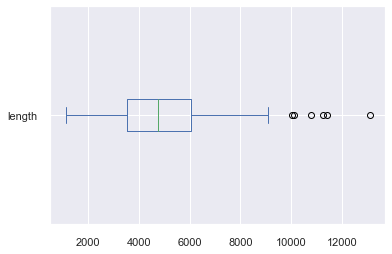

In [86]:
# Box plot:
df['length'].plot(kind='box', vert=False)

## Histogram:

<AxesSubplot:ylabel='Frequency'>

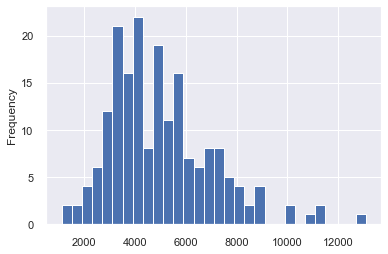

In [87]:
# Histogram:
df['length'].plot(kind='hist', bins=30)


# Create a pipeline:

Below are the steps taken to process the texts.

In [88]:
nlp = spacy.load("da_core_news_md")

STOPWORDS_DANISH = set(stopwords.words('danish'))

stopwords_to_include = {'nævnet', 'stadfæstede', 'januar', 'februar', 'marts', 'april',
'maj', 'juni', 'juli', 'august', 'september', 'oktober', 'november', 'december', 'jf', 'ansøger'}

STOPWORDS_DANISH |= stopwords_to_include 

PUNCTUATION_TO_REMOVE = '–«!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~»●·’“”'

In [89]:
def remove_punctuation(text):
    """custom function to remove the punctuation"""
    return text.translate(str.maketrans('', '', PUNCTUATION_TO_REMOVE))


def remove_stopwords(tokens):
    """custom function to remove stopwords"""
    return [t for t in tokens if t.lower() not in STOPWORDS_DANISH]


def tokenize(text):
    """the following expression matches tokens consisting of at least one letter (\p{L}), 
    preceded and followed by an arbitrary sequence of alphanumeric characters 
    (\w includes digits, letters, and underscore) and hyphens (-)"""
    return re.findall(r'[\w-]*\p{L}[\w-]*', text)

# def tokenize(text):
#     doc = nlp.tokenizer(' '.join(text))
#     return [token.text for token in doc]

def drop_single_letter_words(text):
    return [w for w in text if len(w) > 1]


def lemmatize(text):
    """custom function to lemmatize text"""
    doc = nlp(' '.join(text))
    # pos_tagged_text = text.pos
    return [token.lemma_ for token in doc]


# def remove_junk(text):
#     # Creating a spacy object
#     doc = nlp(' '.join(text))
#     # Checking if POS tag is X and printing them
#     for token in doc:
#         if token.pos_ == 'X':
#             print(token.text)
#     # Removing the tokens whose POS tag is junk.
#     clean_doc = [token.text for token in doc if not token.pos_ == 'X']

#     return clean_doc


Steps can be added or removed from the pipeline.

In [90]:
pipeline = [str.lower, remove_punctuation, tokenize, remove_stopwords,
            lemmatize, drop_single_letter_words]


def process(text, pipeline):
    tokens = text
    for transform in pipeline:
        tokens = transform(tokens)
    return tokens


In [91]:
# Apply the process pipeline:
df['tokens'] = df['text'].apply(process, pipeline=pipeline)

# Add column to see the number of tokens:
df['num_tokens'] = df['tokens'].map(len)

In [92]:
# df.head()
df['stadfæster'] = df['text'].str.contains('stadfæster')

# Analysis:

# Frequency analysis:

Here we count the most frequent tokens in the **whole** corpus.


In [93]:
# Transform the counter into a Pandas DataFrame with the following function:

"""
The tokens make up the index of the DataFrame, while the frequency values are stored in a column named freq. 
The rows are sorted so that the most frequent words appear at the head.
The last parameter of count_words defines a minimum frequency of tokens to be included in the result. 
Its default is set to 2 to cut down on tokens occurring only once.
"""

def count_words(df, column='tokens', preprocess=None, min_freq=2):
    # process tokens and update counter
    def update(doc):
        tokens = doc if preprocess is None else preprocess(doc)
        counter.update(tokens)
    # create counter and run through all data
    counter = Counter() 
    df[column].map(update)
    # transform counter into a DataFrame
    freq_df = pd.DataFrame.from_dict(counter, orient='index', columns=['freq']) 
    freq_df = freq_df.query('freq >= @min_freq')
    freq_df.index.name = 'token'
    return freq_df.sort_values('freq', ascending=False)

In [94]:
# See ten most frequent words in the whole corpus:

freq_df = count_words(df) 
freq_df.head(10)

,freq
token,
ansøger,4331
Kuwait,1378
forklare,1237
flygtningenævn,1128
oplyse,817
myndighed,795
mandlig,794
asylmotiv,747
ved,737


[Text(0.5, 0, 'Frequency'), Text(0, 0.5, 'Token'), Text(0.5, 1.0, 'Top Words')]

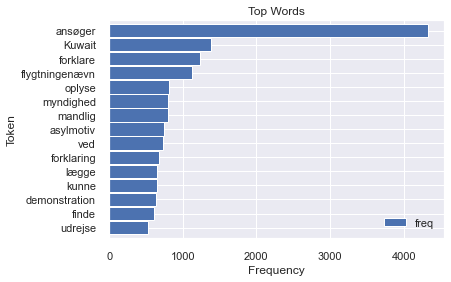

In [95]:
# Plot the results:
ax = freq_df.head(15).plot(kind='barh', width=0.95) 
ax.invert_yaxis()
ax.set(xlabel='Frequency', ylabel='Token', title='Top Words')

# Keyword in context (KWIC):

KWIC analysis produces a list of text fragments of equal length showing the left and right context of a keyword.

In [96]:
"""
The function iteratively collects the keyword contexts by applying the add_kwic function to each document with map. 
By default, the function returns a list of tuples of the form (left context, keyword, right context). 
If print_samples is greater than 0, a random sample of the results is printed. 
Sampling is especially useful with lots of documents because the first entries of the list 
would otherwise stem from a single or a very small number of documents.
"""

def kwic(doc_series, keyword, window=35, print_samples=5):
    def add_kwic(text):
        kwic_list.extend(keyword_in_context(text, keyword, ignore_case=True, window_width=window))

    kwic_list = []
    doc_series.map(add_kwic)

    if print_samples is None or print_samples == 0:
        return kwic_list
    else:
        k = min(print_samples, len(kwic_list))
        print(f'{k} random samples out of {len(kwic_list)} ' +
              f"contexts for '{keyword}':")
        for sample in random.sample(list(kwic_list), k):
            print(re.sub(r'[\n\t]', ' ', sample[0]) + ' ' +
                  sample[1]+' ' +
                  re.sub(r'[\n\t]', ' ', sample[2]))


Bellow we apply KWIC for `stk` keyword found from the frequency analysis and print 10 random context appearances.

The call is made to the original untokenized & unprocessed dataset.

In [97]:
kwic(df['text'], 'stk', print_samples=10)

10 random samples out of 363 contexts for 'stk':
 i medfør af udlændingelovens § 7,  stk . 1 og stk. 2, er opfyldt. Flygtnin
t følger af udlændingelovens § 40,  stk . 1, at det påhviler en asylansøger
adelse efter udlændingelovens § 7,  stk . 1 eller stk. 2, ikke er opfyldt. 
udlændingelovens § 7, stk. 1 eller  stk . 2.” hjem/2018/100/JAH
 som nævnt i udlændingelovens § 7,  stk . 1 eller stk. 2. Det tilføjes, at 
dlændingelovens § 7, stk. 1, eller  stk . 2, er opfyldt, stadfæster Flygtni
adelse efter udlændingelovens § 7,  stk . 1 eller stk. 2, er opfyldt.  Flyg
ngenævnets forretningsordens § 36,  stk . 1, og nævnet har derfor besluttet
 omfattet af udlændingelovens § 7,  stk . 1 eller stk. 2. Flygtningenævnet 
anmark efter udlændingelovens § 7,  stk . 1, eller § 7, stk. 2. Flygtningen


KWIC for `opholdstilladelse`.

In [98]:
kwic(df['text'], 'opholdstilladelse', print_samples=10)

10 random samples out of 228 contexts for 'opholdstilladelse':
. [F’s] ægtefælle, [B], fik i 2015  opholdstilladelse  i Danmark. Det lægges derfor til g
dsynliggjort, at betingelserne for  opholdstilladelse  efter udlændingelovens § 7, stk. 1
 at klageren [i sommeren] 2016 fik  opholdstilladelse  på grundlag af oplysninger om, at 
ageren at nægte at forlænge hendes  opholdstilladelse , navnlig på grund de hensyn, der e
landet kan ikke i sig selv medføre  opholdstilladelse  efter udlændingelovens § 7. Ansøge
beråbt af ansøgerne, ikke føre til  opholdstilladelse  i medfør af udlændingelovens § 7. 
. [F’s] ægtefælle, [B], fik i 2015  opholdstilladelse  i Danmark. Det lægges derfor til g
landet kan ikke i sig selv medføre  opholdstilladelse  efter udlændingelovens § 7. Ansøge
dsynliggjort, at betingelserne for  opholdstilladelse  efter udlændingelovens § 7, stk. 1
raf, at en udlænding, der søger om  opholdstilladelse  efter udlændingelovens § 7, må san


# N-gram analysis:

**N-grams** are neighboring sequences of items (words, letters, symbols) in a document. 

Most of the times a probability is assigned to the occurrence of a N-gram (or a word occurring next in a sequence of words). This can help decide which N-grams can be chunked together to form single entities or make predictions for next words (other possible use cases include spelling corrections).  

[Here](https://web.stanford.edu/~jurafsky/slp3/slides/LM_4.pdf), are some slides from Stanford which provide an introduction to N-gram models and the math that goes with it. 

In [99]:
def generate_N_grams(text, ngram=1):
    """"custom function to generate n-grams"""
    words = [word for word in text.split(
        " ") if word not in set(STOPWORDS_DANISH)]
    # print("Sentence after removing stopwords:", words)
    # Use the zip function to help us generate n-grams
    temp = zip(*[words[i:] for i in range(0, ngram)])
    # Concatentate the tokens into ngrams and return
    ans = [' '.join(ngram) for ngram in temp]
    return ans


In [100]:
df['tokens_joined'] = [' '.join(token) for token in df['tokens']]

In [101]:
values = defaultdict(int)

# Get the count of every bigram in the data set from last processed column:
for text in df['tokens_joined']:
    for word in generate_N_grams(text, 2):
        values[word] += 1

In [102]:
# Focus on more frequently occuring words.
# Sort in descending order with respect to the column of interest:
df_processed = pd.DataFrame(
    sorted(values.items(), key=lambda x: x[1], reverse=True))

# Ten first values of the first column:
c1 = df_processed[0][:10]
# Ten first values of the second column:
c2 = df_processed[1][:10]


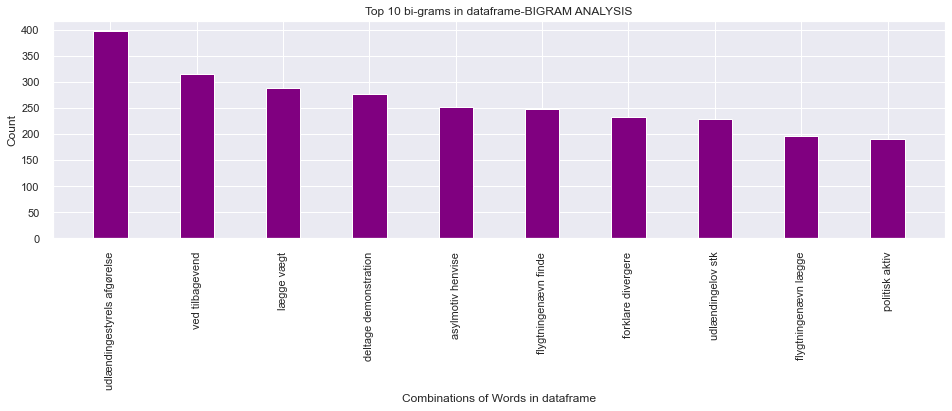

In [103]:
plt.figure(1, figsize=(16, 4))
plt.bar(c1, c2, color='purple',
        width=0.4)
plt.xlabel("Combinations of Words in dataframe")
plt.xticks(rotation=90)
plt.ylabel("Count")
plt.title("Top 10 bi-grams in dataframe-BIGRAM ANALYSIS")
# plt.savefig("dataset-bigram.png")
plt.show()


# TF-IDF

**Term Frequency (TF):**

The number of times a word appears in a document divded by the total number of words in the document. Every document has its own term frequency.

A value close to 1 indicates this term is very important to the document — and primarily composed of it. A low value could mean this term is not very important.

**Inverse Data Frequency (IDF):**

The log of the number of documents divided by the number of documents that contain the word w. Inverse data frequency determines the weight of rare words across all documents in the corpus.

A value close to 0 indicates the term is very common — and not very helpful in differentiating this document from another. A higher value indicates the term is not very common and could be crucial to understanding the theme of this document.

The **TF-IDF** is the multiplication of TF by IDF.

A value close to 0 indicates the term is not important either in the corpus or the document or both. A larger value indicates the term is unique for the document or the corpus or both. This value works best in relation to other terms in the same document, and other documents.

In [104]:
# Get the column of interest:
docs = df['tokens_joined'].tolist()

# Create a vocabulary of words,eliminate stop words if any:

cv = CountVectorizer(stop_words=STOPWORDS_DANISH)
word_count_vector = cv.fit_transform(docs)

# Get shape of resulting vector:
word_count_vector.shape


(189, 4244)

In [105]:
word_count_vector = cv.fit_transform(docs)

# Look at 10 words from our vocabulary:
list(cv.vocabulary_.keys())[:10]


['udlændingestyrels',
 'afgørelse',
 'vedrørende',
 'mandlig',
 'statsborger',
 'ukendt',
 'hjemland',
 'indrejst',
 'flygtningenævne',
 'udtalteflygtningenævn']

In [106]:
tfidf_transformer = TfidfTransformer(smooth_idf=True, use_idf=True)
tfidf_transformer.fit(word_count_vector)

# Add pretty printer:
pp = pprint.PrettyPrinter(indent=4)

# Look at the IDF values:
pp.pprint(tfidf_transformer.idf_)


array([5.55387689, 5.55387689, 5.55387689, ..., 5.55387689, 3.2512918 ,
       1.09373248])


In [107]:
# Sorts the values in the vector while preserving the column index
def sort_coo(coo_matrix):
    tuples = zip(coo_matrix.col, coo_matrix.data)
    return sorted(tuples, key=lambda x: (x[1], x[0]), reverse=True)


def extract_top_n_from_vector(feature_names, sorted_items, topn=10):
    """get the feature names and tf-idf score of top n items"""

    # Use only topn items from vector
    sorted_items = sorted_items[:topn]

    score_vals = []
    feature_vals = []

    for idx, score in sorted_items:
        fname = feature_names[idx]

        # Keep track of feature name and its corresponding score
        score_vals.append(round(score, 3))
        feature_vals.append(fname)

    # Create a tuples of feature,score
    # results = zip(feature_vals,score_vals)
    results = {}
    for idx in range(len(feature_vals)):
        results[feature_vals[idx]] = score_vals[idx]

    return results


In [108]:
# We only need to do this once:
feature_names = cv.get_feature_names_out()

# Generate tf-idf for all documents in list. docs has 192 documents:
tf_idf_vector = tfidf_transformer.transform(cv.transform(docs))

results = []
for i in range(tf_idf_vector.shape[0]):

    # get vector for a single document
    curr_vector = tf_idf_vector[i]

    # sort the tf-idf vector by descending order of scores
    sorted_items = sort_coo(curr_vector.tocoo())

    # extract only the top n; n here is 10
    keywords = extract_top_n_from_vector(feature_names, sorted_items, 10)

    results.append(keywords)

df_tfIDF = pd.DataFrame(zip(docs, results), columns=['doc', 'keywords'])
# df_tfIDF.shape
df_tfIDF


,doc,keywords
0,udlændingestyrels afgørelse vedrørende mandlig...,"{'myanmar': 0.412, 'rohingya': 0.308, 'lejr': ..."
1,udlændingestyrels afgørelse vedrørende mandlig...,"{'algeri': 0.345, 'algerium': 0.329, 'frankrig..."
2,udlændingestyrels afgørelse vedrørende mandlig...,"{'sudan': 0.314, 'sydsudan': 0.221, 'bla': 0.1..."
3,udlændingestyrels afgørelse vedrørende mandlig...,"{'somalia': 0.453, 'alshabaab': 0.436, 'kenya'..."
4,hjemvise udlændingestyrels afgørelse vedrørend...,"{'eritreisk': 0.418, 'eritrea': 0.365, 'etiopi..."
...,...,...
184,udlændingestyrels afgørelse vedrørende mandlig...,"{'fader': 0.515, 'liyu': 0.354, 'police': 0.30..."
185,udlændingestyrels afgørelse vedrørende mandlig...,"{'onlf': 0.446, 'police': 0.318, 'liyu': 0.318..."
186,hjemvise udlændingestyrels afgørelse vedrørend...,"{'burde': 0.464, 'hjemvise': 0.249, 'etiopien'..."
187,udlændingestyrels afgørelse vedrørende mandlig...,"{'soldat': 0.546, 'burmesisk': 0.221, 'burma':..."


In [109]:
# Create a dictionary from results list of dictionaries:
my_dict = dict(ChainMap(*results))

c = Counter(my_dict)

# Returns top 20 most common pairs:
most_common = c.most_common(20)

# For getting the keys from `most_common`:
my_keys = [key for key, val in most_common]

pp.pprint(most_common)


[   ('klager', 0.826),
    ('officer', 0.647),
    ('taliban', 0.596),
    ('libyen', 0.549),
    ('soldat', 0.546),
    ('ægtefælle', 0.524),
    ('police', 0.52),
    ('liyu', 0.52),
    ('senegal', 0.484),
    ('tjetjenie', 0.482),
    ('israel', 0.476),
    ('sierra', 0.475),
    ('leone', 0.475),
    ('burde', 0.464),
    ('libysk', 0.456),
    ('somalia', 0.453),
    ('bøde', 0.444),
    ('ghanesisk', 0.44),
    ('hær', 0.44),
    ('holland', 0.44)]


# Topic Modelling:

## Latent Dirichlet Allocation (LDA):

For a given corpus, a topic model estimates a topic distribution for each of its documents (i.e., a a distribution of weights over a set of topics), where a topic is itself a distribution of weights over the vocabulary of the corpus. The most weighted words of each topic are syntactically and/or semantically related, given that collection of documents. This means that two distinct topics share the exact same vocabulary, but have different weight distributions.

In [110]:
# Utility function to display topics produced by Topic Modelling
def display_topics(model, features, num_top_words=5):
    for topic, word_vector in enumerate(model.components_):
        total = word_vector.sum()
        largest = word_vector.argsort()[::-1] # inverts sort order
        print("\nTopic %02d" % topic)
        for i in range(0, num_top_words):
            print(" %s (%2.2f)" % (features[largest[i]], word_vector[largest[i]]*100.0/total))

In [111]:
count_text_vectorizer = CountVectorizer(stop_words=STOPWORDS_DANISH, min_df=2, max_df=0.7)
count_text_vectors = count_text_vectorizer.fit_transform(df['tokens_joined'])

### Coherence Score:

Compute the coherence score is essentially a measure of how similar the words assigned to each topic are in terms of semantic value. The higher the score, the better.

Compute the coherence score for LDA models with 2 to 10 topics and see which number of topics leads to the highest coherence score.

Topic coherence in essence measures the human interpretability of a topic model. Traditionally perplexity has been used to evaluate topic models however this does not correlate with human annotations at times. Topic coherence is another way to evaluate topic models with a much higher guarantee on human interpretability. Thus this can be used to compare different topic models among many other use-cases.

In [112]:
best_num = float('NaN')
best_score = 0

# Compute the coherence scores for each number of topics
for i in range(2, 11):

    # Create lda model with i topics
    lda_text_model = LatentDirichletAllocation(n_components=i, random_state=42)
    W_lda_text_matrix = lda_text_model.fit_transform(count_text_vectors)
    H_lda_text_matrix = lda_text_model.components_

    # Obtain the coherence score
    coherence_model = metric_coherence_gensim(measure='c_v', 
                        top_n=25, 
                        topic_word_distrib=H_lda_text_matrix, 
                        dtm=W_lda_text_matrix, 
                        vocab=np.array([x for x in count_text_vectorizer.vocabulary_.keys()]), 
                        texts=df['tokens'])
    coherence_score = np.around(coherence_model, 2)
    for score in coherence_score:
        if score > best_score:
            best_num = i
            best_score = score

print(f'The coherence score ({best_score}) is highest with {best_num} topics.')

The coherence score (0.76) is highest with 9 topics.


Build the model with the best number of topics and see them:

In [113]:
lda_model = LatentDirichletAllocation(n_components=best_num, random_state=42)
W_lda_model_matrix = lda_model.fit_transform(count_text_vectors)
H_lda_model_matrix = lda_model.components_

In [114]:
display_topics(lda_model, count_text_vectorizer.get_feature_names_out())


Topic 00
 eritrea (6.50)
 sudan (2.99)
 etiopien (2.38)
 eritreisk (1.79)
 statsborgerskab (1.16)

Topic 01
 demonstration (1.25)
 bidoon (1.01)
 bidooner (0.88)
 kvindelig (0.85)
 deltage (0.83)

Topic 02
 demonstration (2.30)
 kvindelig (2.07)
 deltage (1.54)
 dag (1.53)
 bopæl (1.41)

Topic 03
 klager (5.15)
 syrien (1.43)
 syrisk (1.40)
 sommer (1.24)
 fremgå (1.17)

Topic 04
 far (1.57)
 ansøgere (1.50)
 divergere (1.03)
 bopæl (0.98)
 dag (0.91)

Topic 05
 demonstration (2.13)
 kvindelig (2.11)
 videre (1.47)
 oplysnings (1.40)
 bopæl (1.40)

Topic 06
 klager (4.97)
 ægtefælle (2.11)
 opholdstilladelse (1.73)
 danmark (1.34)
 navn (1.04)

Topic 07
 demonstration (3.71)
 bidoon (2.87)
 deltage (2.67)
 rettighed (1.36)
 tilbageholde (1.21)

Topic 08
 demonstration (1.90)
 oplysning (1.77)
 barn (1.49)
 følge (1.17)
 ansøgere (1.17)


Visualise the topics produced by LDA:

In [115]:
lda_display = pyLDAvis.sklearn.prepare(lda_text_model, count_text_vectors, count_text_vectorizer, sort_topics=False)

pyLDAvis.display(lda_display)

/Users/jnap/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
/Users/jnap/opt/anaconda3/lib/python3.9/site-packages/pyLDAvis/_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  default_term_info = default_term_info.sort_values(
/Users/jnap/opt/anaconda3/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/jnap/opt/anaconda3/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  

Each bubble in the plot represents a topic. The size of the bubble represents the proportion of cases that contain the topic, with a larger bubble corresponding to a higher proportion. 

The distance between the bubbles represents the similarity between the topics; the shorter the distance, the more similar the topics.

The bars in the bar chart represent the term frequency for each of the words. The blue bars show the overall term frequency in the collection of documents, whereas the red bars show the term frequency for the selected topic.